# Fitting Gaussian Mixture Models with EM

In this assignment you will
* implement the EM algorithm for a Gaussian mixture model
* apply your implementation to cluster images
* explore clustering results and interpret the output of the EM algorithm  

In [68]:
import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

### Dataset

To help us develop and test our implementation, we will generate some observations from a mixture of Gaussians and then run our EM algorithm to discover the mixture components. We'll begin with a function to generate the data, and a quick plot to visualize its output for a 2-dimensional mixture of three Gaussians.

Now we will create a function to generate data from a mixture of Gaussians model. 

In [2]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [3]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[1., .7], [0, .7]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

In [4]:
assert len(data) == 100
assert len(data[0]) == 2
print 'Checkpoint passed!'

Checkpoint passed!


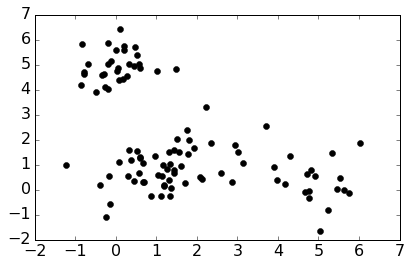

In [5]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Log likelihood 
We provide a function to calculate log likelihood for mixture of Gaussians. The log likelihood quantifies the probability of observing a given set of data under a particular setting of the parameters in our model. We will use this to assess convergence of our EM algorithm; specifically, we will keep looping through EM update steps until the log likehood ceases to increase at a certain rate.

In [6]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

### Implementation

You will now complete an implementation that can run EM on the data you just created. It uses the `loglikelihood` function we provided above.

Fill in the places where you find ## YOUR CODE HERE. There are seven places in this function for you to fill in.

Hint: Some useful functions

* [multivariate_normal.pdf](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html): lets you compute the likelihood of seeing a data point in a multivariate Gaussian distribution.
* [np.outer](http://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html): comes in handy when estimating the covariance matrix from data.

In [69]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                # YOUR CODE HERE
                resp[j, k] = multivariate_normal.pdf(ll_trace[j], means[k],covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            # YOUR CODE HERE
            weights[k] = counts[k]/num_data
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = 0
            for j in range(num_data):
                # YOUR CODE HERE
                weighted_sum += sum(ll_trace[j][k] * weights[k])
            # YOUR CODE HERE
            means[j] = weighted_sum/num_data
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                # YOUR CODE HERE (Hint: Use np.outer on the data[j] and this cluster's mean)
                weighted_sum += sum(ll_trace[j][k] * weights[k])
            # YOUR CODE HERE
            covariances[k] = (1/num_data) * np.outer((data[j]-means[k]),(data[j]-means[k]).T)
          
        
        # Compute the loglikelihood at this iteration
        # YOUR CODE HERE
        ll_latest = loglikelihood(data, weights[k], means[k], covariances[k])
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [67]:
data[0]

array([ 0.31845368,  5.03182099])

In [64]:
initial_means = [data[x] for x in chosen]
initial_means

[array([ 0.19570654,  5.73836612]),
 array([ 6.01348014,  1.87722666]),
 array([ 0.52699679,  5.37301739])]

In [70]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0


IndexError: list index out of range